# Double-bracket Iteration other cost functions

This notebook presents two additional cost functions for the double-bracket flow: least-squares and energy fluctuation with their respectice scheduling methods.

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration, DoubleBracketCostFunction
from qibo.models.dbi.utils import *
from qibo.models.dbi.utils_scheduling import *

### Least-squares

The cost function is defined as: $\frac{1}{2}||D-H_k||^2 =\frac{1}{2}(||D||^2+||H||^2) -Tr(D H_k)$ as in (the negative of https://epubs.siam.org/doi/abs/10.1137/S0036141092229732?journalCode=sjmael) We seek to minimize this function at each DBF iteration. For numerical optimizations, we also ignore the norm of H term as for a given hamiltonian it is fixed through out the flow.


In [2]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 5
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)



[Qibo 0.2.9|INFO|2024-05-29 12:15:54]: Using numpy backend on /CPU:0


In [3]:
# generate data for plotting sigma decrease of the first step
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))/2**nqubits
s_space = np.linspace(1e-5, 1.0, 500)
off_diagonal_norm_diff = []
potential = []
for s in s_space:
    dbi_eval = deepcopy(dbi)
    dbi_eval(s,d=d)
    off_diagonal_norm_diff.append(dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)
    potential.append(dbi_eval.least_squares(d=d))

# grid_search
step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search,d=d)
print('grid_search step:', step_grid)
# hyperopt
step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d, max_evals=100, step_max=0.6)
print('hyperopt_search step:', step_hyperopt)
# polynomial
step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d, n=3)
print('polynomial_approximation step:', step_poly)

grid_search step: 0.6060645454545454
100%|██████████| 100/100 [00:00<00:00, 846.91trial/s, best loss: -30.633516395890517]
hyperopt_search step: 0.5991179894176409
polynomial_approximation step: 0.5267891182131145


The minimum for cost function in the tested range is: 0.6060645454545454


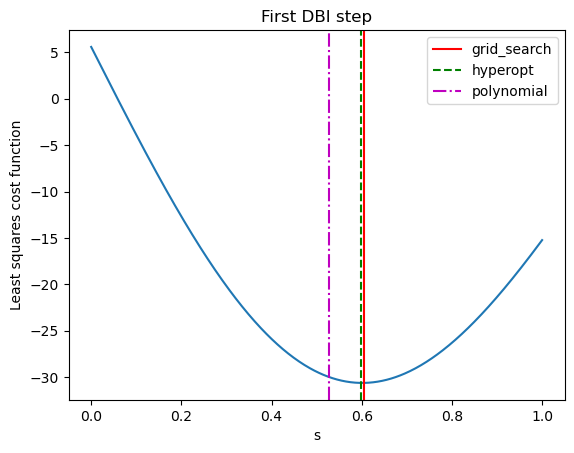

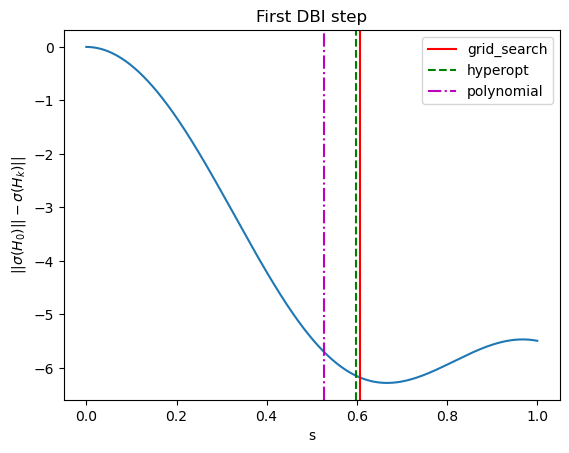

In [4]:
# Plot the results
plt.figure()
plt.plot(s_space, potential)
plt.xlabel('s')
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.title('First DBI step')
plt.ylabel('Least squares cost function')
plt.legend()
plt.figure()
plt.plot(s_space, off_diagonal_norm_diff)
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.ylabel(r'$||\sigma(H_0)||-\sigma(H_k)||$')
plt.xlabel('s')
plt.title('First DBI step')
plt.legend()
print('The minimum for cost function in the tested range is:', step_grid)

Comparison of the least-squares cost function with the original cost function using the polynomial scheduling method

In [5]:
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
off_diagonal_norm_diff = [dbi.off_diagonal_norm]
off_diagonal_norm_diff_least_squares = [dbi.off_diagonal_norm]
iters = 100
dbi_ls = deepcopy(dbi)
cost = DoubleBracketCostFunction.off_diagonal_norm
dbi_od = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
for _ in range(iters):
    step_poly = dbi_od.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
    dbi_od(step_poly,d=d)
    step_poly = dbi_ls.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
    dbi_ls(step_poly,d=d)
    off_diagonal_norm_diff.append(dbi_od.off_diagonal_norm)
    off_diagonal_norm_diff_least_squares.append(dbi_ls.off_diagonal_norm)

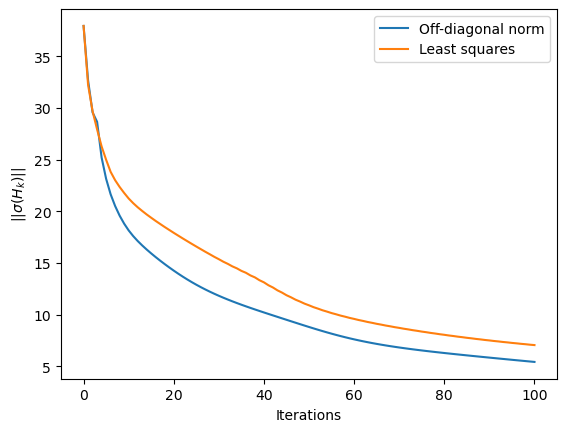

In [6]:
plt.figure()
plt.plot(range(iters+1), off_diagonal_norm_diff, label=r'Off-diagonal norm')
plt.plot(range(iters+1), off_diagonal_norm_diff_least_squares, label=r'Least squares')
plt.xlabel('Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()


### Energy fluctuation

This cost function is defined as: $\Xi_k^2 (\mu) = \langle \mu | H_k^2| \mu \rangle - \langle \mu | H_k| \mu \rangle^2$. We must specify the state $| \mu \rangle$ for which we want to minimize the fluctuation. The overall diagonalization isn't guaranteed.


In [7]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 3
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the energy fluctuation cost function
cost = DoubleBracketCostFunction.off_diagonal_norm
# define the state
state = np.zeros(2**nqubits)
state[3] = 1
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost, ref_state=state)

[Qibo 0.2.9|INFO|2024-05-29 12:15:55]: Using numpy backend on /CPU:0


In [8]:
# generate data for plotting sigma decrease of the first step
d = np.diag(np.linspace(2**nqubits,1,2**nqubits))/2**nqubits
s_space = np.linspace(-1, 1, 1000)
off_diagonal_norm_diff = []
fluctuation = []
for s in s_space:
    dbi_eval = deepcopy(dbi)
    dbi_eval(s,d=d)
    off_diagonal_norm_diff.append(dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)
    fluctuation.append(dbi_eval.energy_fluctuation(state=state))

# grid_search
step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search,d=d)
print('grid_search step:', step_grid)
# hyperopt
step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d, max_evals=100, step_max=0.6)
print('hyperopt_search step:', step_hyperopt)
# polynomial
step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d, n=3)
print('polynomial_approximation step:', step_poly)


grid_search step: 0.6565690909090909
100%|██████████| 100/100 [00:00<00:00, 1239.19trial/s, best loss: 10.532755662184366]
hyperopt_search step: 0.5995386291300258
polynomial_approximation step: 0.4860935299211704


The minimum for cost function in the tested range is: 0.6565690909090909


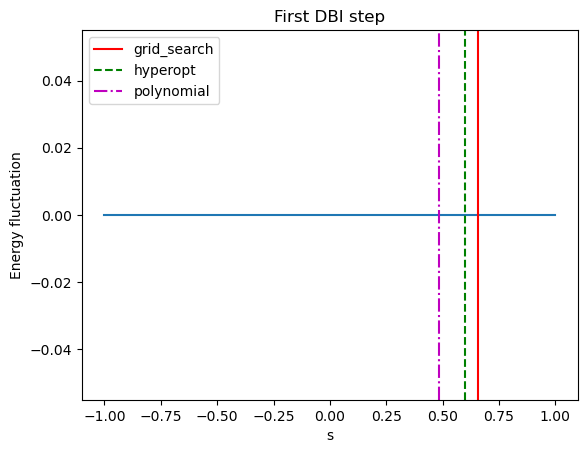

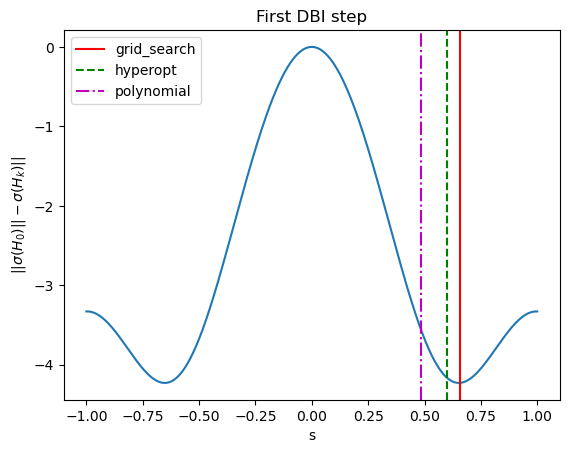

In [9]:
# Plot the results
plt.figure()
plt.plot(s_space, fluctuation)
plt.xlabel('s')
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label ='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.title('First DBI step')
plt.ylabel('Energy fluctuation')
plt.legend()
plt.figure()
plt.plot(s_space, off_diagonal_norm_diff)
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.ylabel(r'$||\sigma(H_0)||-\sigma(H_k)||$')
plt.xlabel('s')
plt.title('First DBI step')
plt.legend()
print('The minimum for cost function in the tested range is:', step_grid)

In [10]:
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
off_diagonal_norm_diff = [dbi.off_diagonal_norm]
energy_fluc = [dbi.energy_fluctuation(state=state)]
iters = 10
dbi_ = deepcopy(dbi)
for _ in range(iters):
    step_poly = dbi_.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
    dbi_(step_poly,d=d)
    off_diagonal_norm_diff.append(dbi_.off_diagonal_norm)
    energy_fluc.append(dbi_.energy_fluctuation(state=state))

Text(0, 0.5, 'Energy fluctuation')

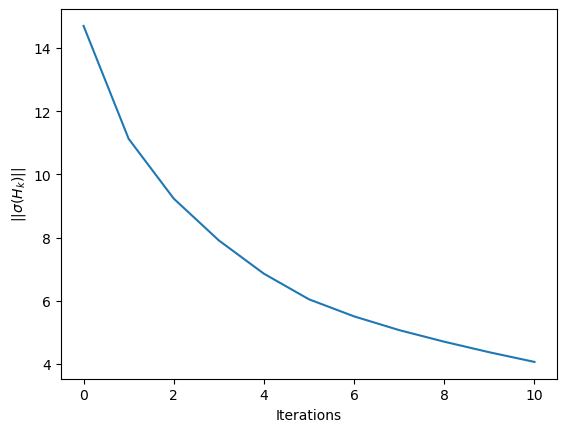

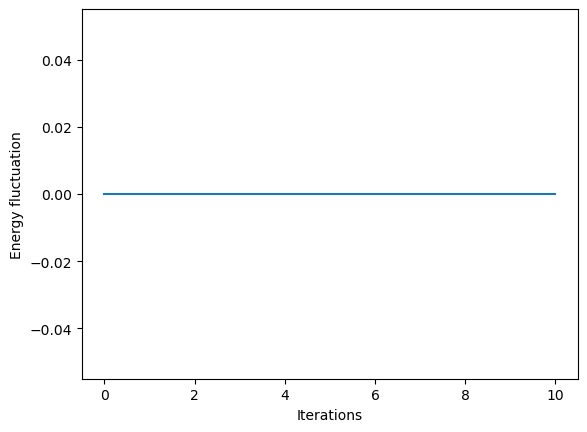

In [11]:
plt.figure()
plt.plot(range(iters+1), off_diagonal_norm_diff)
plt.xlabel('Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')

plt.figure()
plt.plot(range(iters+1), energy_fluc)
plt.xlabel('Iterations')
plt.ylabel(r'Energy fluctuation')


In [12]:
iters = 30
states = [0,1,2,3,4,5,6,7]
energy = np.empty((len(states),iters))


d = (np.diag(np.linspace(1,2**nqubits,2**nqubits)))
for i in range(len(states)):
    dbi_ = deepcopy(dbi)
    dbi_.state = states[i]
    for j in range(iters):
        step_poly = dbi_.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
        if step_poly is not None:
            dbi_(step_poly, d=d)
        energy[i,j] = np.real(dbi_.h.matrix[states[i],states[i]])
    

Eigenvalues: [-9.29150262 -5.21110255 -2.         -2.          1.29150262  4.
  4.          9.21110255]


Text(0.5, 0, 'Iterations')

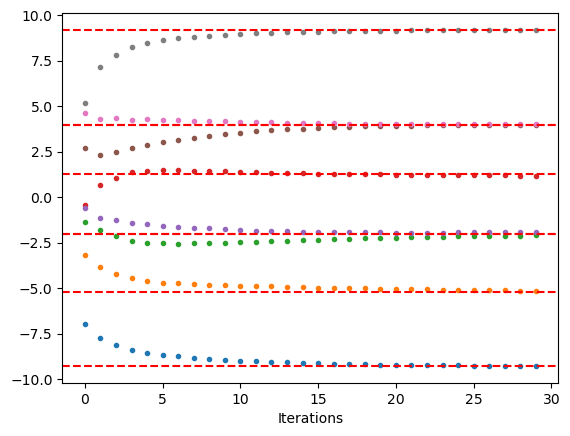

In [13]:
eigvals = np.linalg.eigh(dbi_.h.matrix)[0]
print('Eigenvalues:', eigvals )
plt.figure()
for i in range(len(states)):
    plt.plot(range(iters), energy[i,:],'.', label='State ' + str(states[i]))
for eigvals in eigvals:
    plt.axhline(y=eigvals, color='r', linestyle='--')
plt.xlabel('Iterations')
